# Regression Analysis of Stock Prices Using `stockpy`

In this tutorial, we will demonstrate how to conduct regression analysis on stock price data using a Convolutional Neural Network (CNN) with the `stockpy` library.

## Setting Up

First, import all necessary modules from PyTorch, Pyro, `stockpy`, and other required libraries.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import stockpy
import pyro.distributions as dist
from pyro.infer import Trace_ELBO, TraceMeanField_ELBO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from stockpy.neural_network import *
from stockpy.probabilistic import *

# Data Preparation

Load and preprocess your stock price data for the model.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('../stock/AAPL.csv', parse_dates=True, index_col='Date').dropna(how="any")

# Define features and target
X = df[['Open', 'High', 'Low', 'Volume']]
y = df['Close']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Data Normalization

Standardize the features to have a mean of 0 and a standard deviation of 1.

In [3]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Conversion to PyTorch Tensors

Convert the datasets into PyTorch tensors to feed into the model.

In [4]:
X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_train = torch.tensor(y_train.values, dtype=torch.float)

# Callbacks Configuration

Set up callbacks for early stopping and learning rate scheduling.

In [5]:
from stockpy.callbacks import EarlyStopping, LRScheduler, Checkpoint
from torch.optim.lr_scheduler import StepLR
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=5,
    threshold=0,
    threshold_mode='rel',
    lower_is_better=True)

checkpoint = Checkpoint(
    f_params='best_model_params.pt',       # where to save the model parameters
    monitor='valid_loss_best',             # name of the variable that should be minimized
    f_optimizer='best_optimizer_params.pt',  # where to save the optimizer
    f_history='best_model_history.json',   # where to save the training history
)

# Define the LR scheduler callback
lr_scheduler = LRScheduler(policy=StepLR, step_size=10, gamma=0.7)  # Added this line

# Model Training

Define and train the CNN model using the `stockpy` library.

In [6]:
predictor = CNNRegressor(hidden_size=32)

predictor.fit(X_train, 
              y_train, 
              batch_size=32, 
              lr=0.01, 
              optimizer=torch.optim.Adam, 
              callbacks=[early_stopping, checkpoint, lr_scheduler],
              epochs=50)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     8044.1081     1143.4609  0.0456
      2     6210.5496      704.1196  0.0393


      3     3209.3676      274.4651  0.0451
      4      862.9909      162.9634  0.0483
      5      361.0070      194.6806  0.0464
      6      311.6897      178.0000  0.0463
      7      266.2761      163.6197  0.0406
      8      228.7866      151.8195  0.0388
      9      199.7088      139.0358  0.0398
     10      173.7231      126.7772  0.0343
     11      148.8369      114.6263  0.0388
     12      133.9845      106.0916  0.0395
     13      120.0958       98.9474  0.0399
     14      107.3135       92.6995  0.0885
     15       95.4599       86.9087  0.0449
     16       84.5307       81.7149  0.0345
     17       74.6426       77.1834  0.0340
     18       65.7692       72.5265  0.0341
     19       58.0603       68.3015  0.0336
     20       50.9748       64.3478  0.0366
     21       43.7013       60.1586  0.0360
     22       39.6906       57.1404  0.0335
     23       35.9214       54.2653  0.0342
     24       32.4756       51.6314  0.0327
     25       29.4145       49.0

<class 'stockpy.neural_network._cnn.CNNRegressor'>[initialized](
)

# Prediction and Evaluation

Predict the closing stock prices and evaluate the model's performance.

In [7]:
y_pred = predictor.predict(X_test)

In [8]:
from stockpy.utils import evaluate

mse, mse_squar, mape = evaluate(y_pred=y_pred, y_test=y_test)

/tmp/ipykernel_242305/3963300000.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(y_test[i] - y_pred[i]) < 0.1:
/tmp/ipykernel_242305/3963300000.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(days[i], y_test[i], marker='X', color='white',


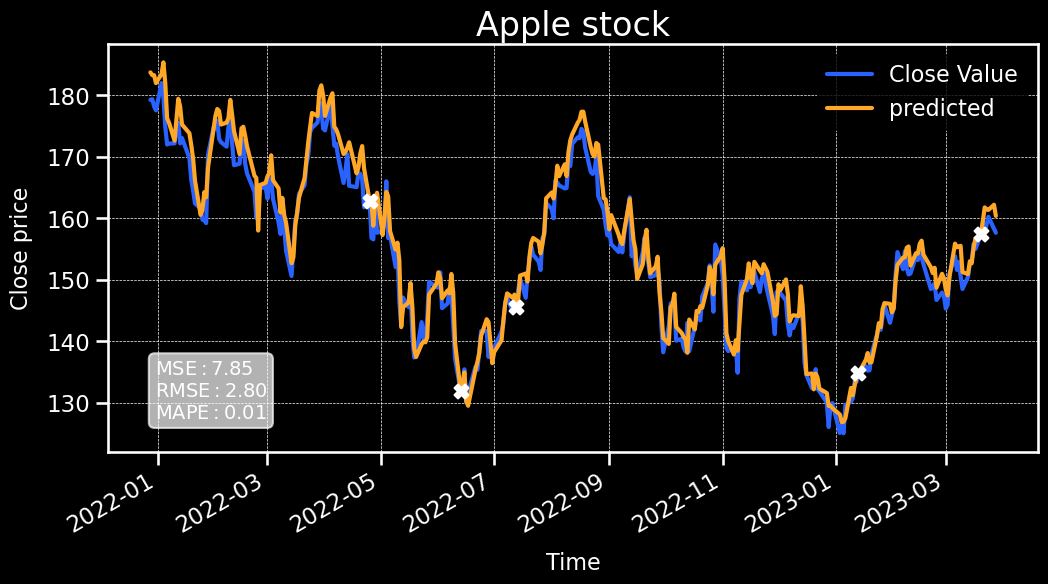

In [9]:
sns.set(style="ticks", context="talk")
plt.style.use('dark_background')
file = '../results/regressor' + predictor.__class__.__name__ + '.png'
fig, ax = plt.subplots(figsize=(12, 6))
days = X[len(X) - len(y_test):].index
ax.plot(days, y_test, label='Close Value', linewidth=3, color='#2962FF')
ax.plot(days, y_pred, label='predicted', linewidth=3, color='#FFA726')
ax.set_title('Apple stock', fontsize=24, color='white')
ax.set_xlabel('Time', fontsize=16, color='white', labelpad=10)
ax.set_ylabel('Close price', fontsize=16, color='white', labelpad=10)
ax.grid(color='white', linestyle='--', linewidth=0.5)

# Add crosses at points where predicted value matches true value
for i in range(len(days)):
    if abs(y_test[i] - y_pred[i]) < 0.1:
        ax.scatter(days[i], y_test[i], marker='X', color='white', 
                        s=100, zorder=2)

# put legend in a white box
ax.legend(fontsize=16, loc='upper right', 
          edgecolor='black')

fig.autofmt_xdate()
# these are matplotlib.patch.Patch properties
textstr = '\n'.join((
    r'$\mathrm{MSE}: %.2f$' % (mse, ),
    r'$\mathrm{RMSE}: %.2f$' % (mse_squar, ),  
    r'$\mathrm{MAPE}: %.2f$' % (mape, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.7)

# place a text box in upper left in axes coords
ax.text(0.05, 0.15, textstr, transform=ax.transAxes, fontsize=14,
        ha='left', va='center', bbox=props)

plt.show()